In [541]:
# fit xgboost on an imbalanced classification dataset
import pandas as pd
import glob
import os
import json
import numpy as np
import inspect
import sys
import math
from numpy import mean
from numpy import std
from numpy import sort
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer,accuracy_score,classification_report, recall_score,confusion_matrix, matthews_corrcoef, roc_auc_score,balanced_accuracy_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve
from copy import deepcopy
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import missingno as msno
import model_tests
import xgboost as xgb
import time
import seaborn as sns
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.pipeline import Pipeline as imbPipeline

## Useful Notebooks

In [ ]:
https://www.kaggle.com/code/michalbrezk/xgboost-classifier-and-hyperparameter-tuning-85/notebook

https://www.davidsbatista.net/blog/2018/02/23/model_optimization/

https://towardsdatascience.com/how-to-compare-two-or-more-distributions-9b06ee4d30bf
    
https://towardsdatascience.com/advanced-pipelines-with-scikit-learn-4204bb71019b

https://www.kaggle.com/code/michalbrezk/xgboost-classifier-and-hyperparameter-tuning-85/notebook

https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/
    
https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e
    
https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d

### Data Ready

In [480]:
df_input = pd.read_csv('../output/model_data_with_nan.csv', sep=',', header=0)
df_input = df_input.drop(['Child','influencer_ratio_total','socialmedia_freq', 'socialmedia_days', 'socialmedia_hours', 'vlog_freq', 'vlog_self', 'vlog_learn'], axis=1)
X = df_input.drop('isInfluencer', axis=1)
y = df_input['isInfluencer']
df_input.groupby('isInfluencer')['Steps'].count()

isInfluencer
0    548
1     96
Name: Steps, dtype: int64

In [481]:
df_input.head()

,isInfluencer,WC,affect,drives,social,polarity,health,cogproc,subjectivity,num_likes,...,BMI,flynn_score,n2b_score,happy_score,prosocial_score,public_indiv_score,esteem_score,fas,age,sex
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,3.4,3.6,5.250000,NaN,2.333333,4.90,8.0,14.0,1
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,6.000000,NaN,NaN,NaN,0.0,14.0,0
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,NaN,4.3,5.333333,NaN,NaN,3.45,8.0,13.0,0
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,NaN,2.5,6.333333,NaN,NaN,NaN,10.0,13.0,0
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.0,3.8,4.4,6.000000,NaN,5.416667,NaN,9.0,13.0,0


In [495]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=3, verbose=1, scoring=None, refit=False,random_seed = random_seed):
        for key in self.keys:
            print("Running RandomizedSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = RandomizedSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,n_iter = 100,
                              return_train_score=True,random_state = random_seed)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def parameter_tuning_score_summary(self,X_train, X_test, y_train, y_test, sort_by='balanced_accuracy_mean_score'):
        def row(key, scores_ba,scores_recall,scores_precision,scores_f1,scores_mcc, params):
            d = {
                 'estimator': key,
                 'balanced_accuracy_mean_score': np.mean(scores_ba),
                 'recall_mean_score': np.mean(scores_recall),
                 'precision_mean_score': np.mean(scores_precision),
                 'f1_mean_score': np.mean(scores_f1),
                 'mcc_mean_score': np.mean(scores_mcc),


            }
            return pd.Series({**params,**d})

        rows = []
        results_dict_full = {}
        results_dict_to_df = {}


        
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores_balanced_acc = []
            scores_recall = []
            scores_precision = []
            scores_f1 = []
            scores_mcc = []
            
            #UNSEEN DATA
            best_estimator = self.grid_searches[k].best_estimator_
            train_predictions = best_estimator.predict(X_train)
            test_predictions = best_estimator.predict(X_test)
            
            cfm_train = confusion_matrix(y_train, train_predictions)
            cfm_test = confusion_matrix(y_test, test_predictions)
            
            #F1 scores for each train/test label
            f1_train = f1_score(y_train, train_predictions)
            f1_test = f1_score(y_test, test_predictions)
            
            #balanced_accuracy score
            balanced_accuracy_train = balanced_accuracy_score(y_train, train_predictions)
            balanced_accuracy_test = balanced_accuracy_score(y_test, test_predictions)           
            
 
            #precision score
            precision_train = precision_score(y_train, train_predictions)
            precision_test = precision_score(y_test, test_predictions) 
            
            #recall score
            recall_train = recall_score(y_train, train_predictions)
            recall_test = recall_score(y_test, test_predictions) 
            
            #mcc score
            mcc_train = matthews_corrcoef(y_train, train_predictions)
            mcc_test = matthews_corrcoef(y_test, test_predictions) 
            
            results_dict_full[str(k)] = {
                         'classifier': k,
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'f1_train': f1_train,
                         'f1_train': f1_test,
                         'balanced_accuracy_train': balanced_accuracy_train,
                         'balanced_accuracy_test': balanced_accuracy_test,
                         'precision_train': precision_train,
                         'precision_test': precision_test,
                         'recall_train': recall_train,
                         'recall_test': recall_test,
                         'mcc_train': mcc_train,
                         'mcc_test': mcc_test,
                         'best_params': self.grid_searches[k].best_params_,
                         'best_estimator': self.grid_searches[k].best_estimator_}
            
            
            results_dict_to_df[str(k)] = {
                         'classifier': k,
                         'train_f1': f1_train,
                         'train_balanced_accuracy': balanced_accuracy_train,
                         'train_precision': precision_train,
                         'train_recall': recall_train,
                         'test_f1': f1_test,
                         'test_balanced_accuracy': balanced_accuracy_test,
                         'test_precision': precision_test,
                         'test_recall': recall_test,
                         'mcc_train': mcc_train,
                         'mcc_test': mcc_test,
            }            
            
            
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test".format(i)+'_balanced_accuracy'
                r = self.grid_searches[k].cv_results_[key]
                scores_balanced_acc.append(r.reshape(len(params),1))
                
                key = "split{}_test".format(i)+'_recall'
                r = self.grid_searches[k].cv_results_[key]   
                scores_recall.append(r.reshape(len(params),1))
                
                key = "split{}_test".format(i)+'_precision'
                r = self.grid_searches[k].cv_results_[key]
                scores_precision.append(r.reshape(len(params),1))
                
                key = "split{}_test".format(i)+'_f1'
                r = self.grid_searches[k].cv_results_[key]   
                scores_f1.append(r.reshape(len(params),1))
                
                key = "split{}_test".format(i)+'_matthews_corrcoef'
                r = self.grid_searches[k].cv_results_[key]   
                scores_mcc.append(r.reshape(len(params),1))

            scores_balanced_acc = np.hstack(scores_balanced_acc)
            scores_recall = np.hstack(scores_recall)
            scores_precision = np.hstack(scores_precision)
            scores_f1 = np.hstack(scores_f1)
            scores_mcc = np.hstack(scores_mcc)





            for p, s_balanced_acc, s_recall,s_precision,s_f1,s_mcc in zip(params,scores_balanced_acc,scores_recall,scores_precision,scores_f1,scores_mcc):
                rows.append((row(k, s_balanced_acc,s_recall,s_precision,s_f1,s_mcc, p)))

                
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'balanced_accuracy_mean_score', 'recall_mean_score','precision_mean_score', 'f1_mean_score', 'mcc_mean_score']
        columns = columns + [c for c in df.columns if c not in columns]

        print('DONE!!!')
        
        return df[columns],results_dict_full,pd.DataFrame.from_dict(results_dict_to_df).T.reset_index().iloc[:,1:]

In [434]:
# # Correlation plot
# df_input.corr().style.background_gradient(cmap='viridis')

In [435]:
# # Missing Values plots
# msno.matrix(df_input)
# plt.show()
# msno.bar(df_input)
# plt.show()

In [574]:
random_seed = 111
np.random.seed(random_seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_seed, stratify = df_input['isInfluencer'])
# X_train, X_test, y_train, y_test = train_test_split(df_train.iloc[:,1:], df_train.iloc[:,:1], test_size=0.2, random_state=42, stratify=df_train['isInfluencer']

# Results 1: Without oversampling or feature selection

In [443]:
models1 = { 
    'AdaBoostClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='median')), ('ab', AdaBoostClassifier(random_state=random_seed))]),
    'XGBoost': imbPipeline(steps=[('i', SimpleImputer(strategy='median')), ('xg', XGBClassifier(random_state=random_seed, scale_pos_weight = 9))]),
    'DummyClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='median')), ('dm', DummyClassifier(random_state=random_seed))]),
}

params1 = {     
     'AdaBoostClassifier':  { 'ab__n_estimators': list(range(1,20,2)),
                            'ab__learning_rate': [(0.97 + x/100) for x in range(0,8)],
                            'ab__algorithm': ['SAMME','SAMME.R']},
    
     'XGBoost':{ 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "xg__learning_rate": [0.01, 0.05,0.10, 0.15, 0.20, 0.25, 0.30] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "xg__max_depth": range(3,21,2),
    # Gamma specifies the minimum loss reduction required to make a split.
    "xg__gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "xg__colsample_bytree": [i/10.0 for i in range(0,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "xg__reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "xg__reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "xg__n_estimators" : [10, 100, 500, 1000, 2000]},
    
      'DummyClassifier' : {},

}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring=['balanced_accuracy','f1','precision','recall','matthews_corrcoef'], n_jobs=3,refit='balanced_accuracy',random_seed=random_seed)
res = helper1.parameter_tuning_score_summary(X_train, X_test, y_train, y_test)
res[2]

Running RandomizedSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Running RandomizedSearchCV for XGBoost.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:15:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for DummyClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


DONE!!!


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,classifier,train_f1,train_balanced_accuracy,train_precision,train_recall,test_f1,test_balanced_accuracy,test_precision,test_recall,mcc_train,mcc_test
0,AdaBoostClassifier,0.294118,0.585987,0.6,0.194805,0.307692,0.591627,0.571429,0.210526,0.28535,0.28668
1,XGBoost,0.802083,0.956621,0.669565,1.0,0.333333,0.615072,0.275862,0.421053,0.781969,0.195377
2,DummyClassifier,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0


##### Will scaling the data change the outcomes?

In [449]:
models1 = { 
    'AdaBoostClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')), ('ab', AdaBoostClassifier(random_state=random_seed))]),
    'XGBoost': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')), ('xg', XGBClassifier(random_state=random_seed, scale_pos_weight = 9))]),
    'DummyClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')), ('dm', DummyClassifier(random_state=random_seed))]),
}

params1 = {     
     'AdaBoostClassifier':  { 'ab__n_estimators': list(range(1,20,2)),
                            'ab__learning_rate': [(0.97 + x/100) for x in range(0,8)],
                            'ab__algorithm': ['SAMME','SAMME.R']},
    
     'XGBoost':{ 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "xg__learning_rate": [0.01, 0.05,0.10, 0.15, 0.20, 0.25, 0.30] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "xg__max_depth": range(3,21,2),
    # Gamma specifies the minimum loss reduction required to make a split.
    "xg__gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "xg__colsample_bytree": [i/10.0 for i in range(0,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "xg__reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "xg__reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "xg__n_estimators" : [10, 100, 500, 1000, 2000]},
    
      'DummyClassifier' : {},

}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring=['balanced_accuracy','f1','precision','recall','matthews_corrcoef'], n_jobs=3,refit='balanced_accuracy',random_seed=random_seed)
res = helper1.parameter_tuning_score_summary(X_train, X_test, y_train, y_test)
res[2]

Running RandomizedSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Running RandomizedSearchCV for XGBoost.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:12:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for DummyClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DONE!!!


,classifier,train_f1,train_balanced_accuracy,train_precision,train_recall,test_f1,test_balanced_accuracy,test_precision,test_recall,mcc_train,mcc_test
0,AdaBoostClassifier,0.356436,0.610034,0.75,0.233766,0.181818,0.548086,0.666667,0.105263,0.372299,0.22614
1,XGBoost,0.527778,0.839397,0.36019,0.987013,0.394366,0.695694,0.269231,0.736842,0.492201,0.28277
2,DummyClassifier,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0


In [450]:
pd.set_option('display.max_rows',res[0].shape[0]+1)
res[0].head(10)

,estimator,balanced_accuracy_mean_score,recall_mean_score,precision_mean_score,f1_mean_score,mcc_mean_score,ab__n_estimators,ab__learning_rate,ab__algorithm,xg__reg_lambda,xg__reg_alpha,xg__n_estimators,xg__max_depth,xg__learning_rate,xg__gamma,xg__colsample_bytree
169,XGBoost,0.614057,0.648333,0.213923,0.321573,0.163809,NaN,NaN,NaN,100,10,100,17,0.05,0.0,0.8
105,XGBoost,0.605611,0.478333,0.240744,0.319909,0.165628,NaN,NaN,NaN,1,10,100,7,0.3,0.4,0.2
127,XGBoost,0.598469,0.726667,0.194267,0.306535,0.141688,NaN,NaN,NaN,0.01,0.01,10,3,0.1,0.3,0.2
164,XGBoost,0.598069,0.506667,0.220948,0.30703,0.146735,NaN,NaN,NaN,10,10,2000,5,0.05,0.0,0.8
139,XGBoost,0.595229,0.494167,0.223011,0.306299,0.144501,NaN,NaN,NaN,10,0.00001,10,5,0.25,0.2,0.4
138,XGBoost,0.592482,0.413333,0.246538,0.30735,0.154186,NaN,NaN,NaN,0.00001,10,100,15,0.3,0.4,0.4
102,XGBoost,0.591394,0.440833,0.232685,0.303594,0.145382,NaN,NaN,NaN,10,10,2000,17,0.3,0.1,0.2
125,XGBoost,0.585157,0.453333,0.223205,0.298364,0.133571,NaN,NaN,NaN,100,10,1000,9,0.3,0.0,0.3
136,XGBoost,0.584338,0.4675,0.216907,0.293781,0.129618,NaN,NaN,NaN,0.1,0.01,10,5,0.15,0.4,0.8
142,XGBoost,0.582013,0.4425,0.218521,0.290971,0.127328,NaN,NaN,NaN,10,10,100,5,0.25,0.3,0.7


In [451]:
res1 = res

# Results 2: With resampling

In [467]:
models1 = { 
    'AdaBoostClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('over', SMOTE(random_state=random_seed)), ('ab', AdaBoostClassifier(random_state=random_seed))]),
    'XGBoost': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')), ('over', SMOTE(random_state=random_seed)), ('xg',XGBClassifier(random_state=random_seed, scale_pos_weight = 9))]),
    'DummyClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('over', SMOTE(random_state=random_seed)), ('dm', DummyClassifier(random_state=random_seed))]),
    'EasyEnsembleClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('eec', EasyEnsembleClassifier(random_state=random_seed))]),
    'BalancedRandomForestClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')), ('brf', BalancedRandomForestClassifier(random_state=random_seed))]),
    'BalancedBaggingClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')), ('bbc', BalancedBaggingClassifier(random_state=random_seed))]),
}

params1 = {     
     'AdaBoostClassifier':  { 'ab__n_estimators': list(range(1,20,2)),
                            'ab__learning_rate': [(0.97 + x/100) for x in range(0,8)],
                            'ab__algorithm': ['SAMME','SAMME.R']},
    
     'XGBoost':{ 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "xg__learning_rate": [0.01, 0.05,0.10, 0.15, 0.20, 0.25, 0.30] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "xg__max_depth": range(3,21,2),
    # Gamma specifies the minimum loss reduction required to make a split.
    "xg__gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "xg__colsample_bytree": [i/10.0 for i in range(0,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "xg__reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "xg__reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
         
    "xg__n_estimators" : [10, 100, 500, 1000, 2000]},
    
      'DummyClassifier' : {},
    
    'EasyEnsembleClassifier' : {'eec__n_estimators': list(range(1,200,20))},
    'BalancedRandomForestClassifier' : { 'brf__n_estimators': list(range(1,200,20)),
                                         'brf__bootstrap': [True, False],
                                         'brf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                                         'brf__max_features': ['auto', 'sqrt'],
                                         'brf__min_samples_leaf': [1, 2, 4],
                                         'brf__min_samples_split': [2, 5, 10],                                       
                                       },
    'BalancedBaggingClassifier' : {'bbc__n_estimators': list(range(1,200,20))},


}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring=['balanced_accuracy','f1','precision','recall','matthews_corrcoef'], n_jobs=3,refit='balanced_accuracy',random_seed = random_seed)
res2 = helper1.parameter_tuning_score_summary(X_train, X_test, y_train, y_test)

Running RandomizedSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Running RandomizedSearchCV for XGBoost.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for DummyClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running RandomizedSearchCV for EasyEnsembleClassifier.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for BalancedRandomForestClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be rem

Running RandomizedSearchCV for BalancedBaggingClassifier.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DONE!!!


,classifier,train_f1,train_balanced_accuracy,train_precision,train_recall,test_f1,test_balanced_accuracy,test_precision,test_recall,mcc_train,mcc_test
0,EasyEnsembleClassifier,0.501629,0.825342,0.334783,1.0,0.346667,0.646651,0.232143,0.684211,0.466731,0.209716
1,BalancedRandomForestClassifier,0.506667,0.825698,0.340807,0.987013,0.328767,0.62488,0.222222,0.631579,0.468796,0.17942
2,BalancedBaggingClassifier,0.684444,0.91895,0.52027,1.0,0.415094,0.684928,0.323529,0.578947,0.660253,0.297512


In [476]:
res2[2]

,classifier,train_f1,train_balanced_accuracy,train_precision,train_recall,test_f1,test_balanced_accuracy,test_precision,test_recall,mcc_train,mcc_test
0,AdaBoostClassifier,0.340278,0.63325,0.232227,0.636364,0.411765,0.70933,0.285714,0.736842,0.193242,0.305697
1,XGBoost,0.669604,0.909032,0.506667,0.987013,0.470588,0.771053,0.326531,0.842105,0.642062,0.395835
2,DummyClassifier,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
3,EasyEnsembleClassifier,0.501629,0.825342,0.334783,1.0,0.346667,0.646651,0.232143,0.684211,0.466731,0.209716
4,BalancedRandomForestClassifier,0.506667,0.825698,0.340807,0.987013,0.328767,0.62488,0.222222,0.631579,0.468796,0.17942
5,BalancedBaggingClassifier,0.684444,0.91895,0.52027,1.0,0.415094,0.684928,0.323529,0.578947,0.660253,0.297512


In [479]:
res1[2]

,classifier,train_f1,train_balanced_accuracy,train_precision,train_recall,test_f1,test_balanced_accuracy,test_precision,test_recall,mcc_train,mcc_test
0,AdaBoostClassifier,0.356436,0.610034,0.75,0.233766,0.181818,0.548086,0.666667,0.105263,0.372299,0.22614
1,XGBoost,0.527778,0.839397,0.36019,0.987013,0.394366,0.695694,0.269231,0.736842,0.492201,0.28277
2,DummyClassifier,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0


# Results 3: Feature Selection

Feature WC: 0.668347
Feature affect: 3.043010
Feature drives: 1.750286
Feature social: 1.099291
Feature polarity: 0.384389
Feature health: 0.923305
Feature cogproc: 1.666952
Feature subjectivity: 4.224217
Feature num_likes: 0.221455
Feature g_num_text: 1.322869
Feature g_num_media: 4.390088
Feature i_num_text: 0.244054
Feature i_num_media: 0.022528
Feature i_num_recepients: 0.003368
Feature Steps: 6.511829
Feature Minutes_MVPA: 0.176677
Feature BMI: 1.938734
Feature flynn_score: 0.455403
Feature n2b_score: 0.086276
Feature happy_score: 4.398866
Feature prosocial_score: 4.093200
Feature public_indiv_score: 8.550033
Feature esteem_score: 6.246661
Feature fas: 4.162187
Feature age: 12.182975
Feature sex: 10.591664


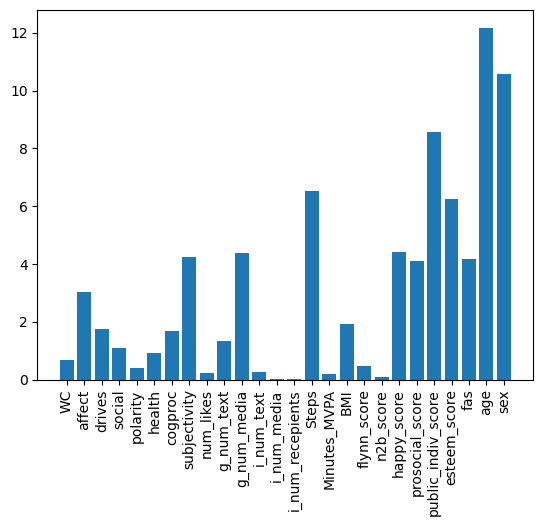

0.6683471174713667
3.0430098294013237
1.7502862687351106
1.0992905687501848
0.38438918930552224
0.9233049761874633
1.6669524226683556
4.224216652004711
0.22145452824291384
1.3228686159870702
4.39008833263741
0.2440542172841144
0.022528186122221454
0.003368123388916478
6.5118285439975745
0.17667681936637625
1.938733574745439
0.45540298269173246
0.08627638630973505
4.398866220138676
4.093200119111323
8.55003312201353
6.246661049432204
4.162187297867069
12.18297504514691
10.591663577392143


['subjectivity',
 'g_num_media',
 'Steps',
 'happy_score',
 'prosocial_score',
 'public_indiv_score',
 'esteem_score',
 'fas',
 'age',
 'sex']

In [506]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot

X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

names = list(X_train.columns)

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (names[i], fs.scores_[i]))
# plot the scores
pyplot.bar(names, fs.scores_)
plt.xticks(rotation = 90)
pyplot.show()

anova_vars = []
for i in range(len(fs.scores_)):
    print(fs.scores_[i])
    if(fs.scores_[i]>4):
        anova_vars.append(names[i])
anova_vars



Feature WC: 0.000000
Feature affect: 0.000000
Feature drives: 0.018110
Feature social: 0.000000
Feature polarity: 0.040515
Feature health: 0.014598
Feature cogproc: 0.030176
Feature subjectivity: 0.000000
Feature num_likes: 0.000000
Feature g_num_text: 0.000000
Feature g_num_media: 0.010405
Feature i_num_text: 0.031606
Feature i_num_media: 0.000000
Feature i_num_recepients: 0.009042
Feature Steps: 0.015155
Feature Minutes_MVPA: 0.000000
Feature BMI: 0.000000
Feature flynn_score: 0.000000
Feature n2b_score: 0.000000
Feature happy_score: 0.000000
Feature prosocial_score: 0.010352
Feature public_indiv_score: 0.011344
Feature esteem_score: 0.016399
Feature fas: 0.005418
Feature age: 0.012445
Feature sex: 0.008556


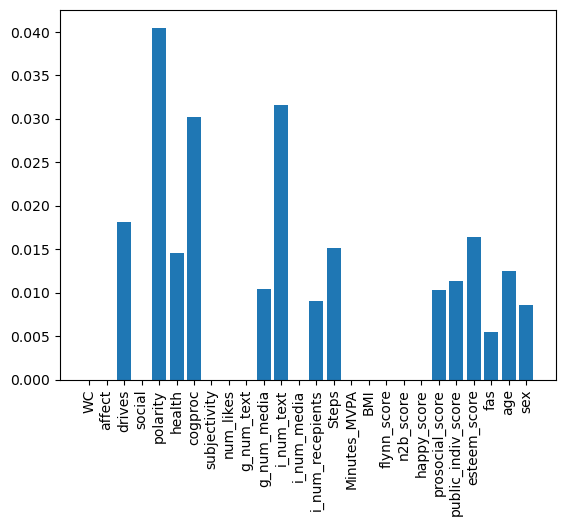

0.0
0.0
0.018109893721257375
0.0
0.04051497738505039
0.014597829596472156
0.03017569500393491
0.0
0.0
0.0
0.010405304935970028
0.03160553978555347
0.0
0.009042052259145228
0.01515516008810569
0.0
0.0
0.0
0.0
0.0
0.010352017740709929
0.011343665171656303
0.01639877510585097
0.005417990154423347
0.012444573536246839
0.008556491492488494


['drives',
 'polarity',
 'health',
 'cogproc',
 'g_num_media',
 'i_num_text',
 'Steps',
 'prosocial_score',
 'public_indiv_score',
 'esteem_score',
 'age']

In [509]:
from sklearn.feature_selection import mutual_info_classif

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (names[i], fs.scores_[i]))
# plot the scores
pyplot.bar(names, fs.scores_)
plt.xticks(rotation = 90)
pyplot.show()


mi_vars = []
for i in range(len(fs.scores_)):
    print(fs.scores_[i])
    if(fs.scores_[i]>0.01):
        mi_vars.append(names[i])
mi_vars

### 3.1 Feature Selection with Anova strategy

In [486]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest



# define the feature selection strategy
fs = SelectKBest(score_func = f_classif,k=10)


models1 = { 
    'AdaBoostClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('anova',fs),('over', SMOTE(random_state=random_seed)), ('ab', AdaBoostClassifier(random_state=random_seed))]),
    'XGBoost': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('anova',fs), ('over', SMOTE(random_state=random_seed)), ('xg',XGBClassifier(random_state=random_seed, scale_pos_weight = 9))]),
    'DummyClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('anova',fs),('over', SMOTE(random_state=random_seed)), ('dm', DummyClassifier(random_state=random_seed))]),
    'EasyEnsembleClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('anova',fs),('eec', EasyEnsembleClassifier(random_state=random_seed))]),
    'BalancedRandomForestClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('anova',fs), ('brf', BalancedRandomForestClassifier(random_state=random_seed))]),
    'BalancedBaggingClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('anova',fs), ('bbc', BalancedBaggingClassifier(random_state=random_seed))]),
}

params1 = {     
     'AdaBoostClassifier':  { 'ab__n_estimators': list(range(1,20,2)),
                            'ab__learning_rate': [(0.97 + x/100) for x in range(0,8)],
                            'ab__algorithm': ['SAMME','SAMME.R']},
    
     'XGBoost':{ 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "xg__learning_rate": [0.01, 0.05,0.10, 0.15, 0.20, 0.25, 0.30] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "xg__max_depth": range(3,21,2),
    # Gamma specifies the minimum loss reduction required to make a split.
    "xg__gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "xg__colsample_bytree": [i/10.0 for i in range(0,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "xg__reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "xg__reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
         
    "xg__n_estimators" : [10, 100, 500, 1000, 2000]},
    
      'DummyClassifier' : {},
    
    'EasyEnsembleClassifier' : {'eec__n_estimators': list(range(1,200,20))},
    'BalancedRandomForestClassifier' : { 'brf__n_estimators': list(range(1,200,20)),
                                         'brf__bootstrap': [True, False],
                                         'brf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                                         'brf__max_features': ['auto', 'sqrt'],
                                         'brf__min_samples_leaf': [1, 2, 4],
                                         'brf__min_samples_split': [2, 5, 10],                                       
                                       },
    'BalancedBaggingClassifier' : {'bbc__n_estimators': list(range(1,200,20))},


}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring=['balanced_accuracy','f1','precision','recall','matthews_corrcoef'], n_jobs=3,refit='balanced_accuracy',random_seed = random_seed)
res3_1 = helper1.parameter_tuning_score_summary(X_train, X_test, y_train, y_test)

Running RandomizedSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Running RandomizedSearchCV for XGBoost.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for DummyClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running RandomizedSearchCV for EasyEnsembleClassifier.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for BalancedRandomForestClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be rem

Running RandomizedSearchCV for BalancedBaggingClassifier.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
DONE!!!


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.2 Feature Selection with Mutual Information strategy

In [489]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest



# define the feature selection strategy
fs = SelectKBest(score_func = mutual_info_classif,k=8)


models1 = { 
    'AdaBoostClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('mi',fs),('over', SMOTE(random_state=random_seed)), ('ab', AdaBoostClassifier(random_state=random_seed))]),
    'XGBoost': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('mi',fs), ('over', SMOTE(random_state=random_seed)), ('xg',XGBClassifier(random_state=random_seed, scale_pos_weight = 9))]),
    'DummyClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('mi',fs),('over', SMOTE(random_state=random_seed)), ('dm', DummyClassifier(random_state=random_seed))]),
    'EasyEnsembleClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('mi',fs),('eec', EasyEnsembleClassifier(random_state=random_seed))]),
    'BalancedRandomForestClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('mi',fs), ('brf', BalancedRandomForestClassifier(random_state=random_seed))]),
    'BalancedBaggingClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('mi',fs), ('bbc', BalancedBaggingClassifier(random_state=random_seed))]),
}

params1 = {     
     'AdaBoostClassifier':  { 'ab__n_estimators': list(range(1,20,2)),
                            'ab__learning_rate': [(0.97 + x/100) for x in range(0,8)],
                            'ab__algorithm': ['SAMME','SAMME.R']},
    
     'XGBoost':{ 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "xg__learning_rate": [0.01, 0.05,0.10, 0.15, 0.20, 0.25, 0.30] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "xg__max_depth": range(3,21,2),
    # Gamma specifies the minimum loss reduction required to make a split.
    "xg__gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "xg__colsample_bytree": [i/10.0 for i in range(0,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "xg__reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "xg__reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
         
    "xg__n_estimators" : [10, 100, 500, 1000, 2000]},
    
      'DummyClassifier' : {},
    
    'EasyEnsembleClassifier' : {'eec__n_estimators': list(range(1,200,20))},
    'BalancedRandomForestClassifier' : { 'brf__n_estimators': list(range(1,200,20)),
                                         'brf__bootstrap': [True, False],
                                         'brf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                                         'brf__max_features': ['auto', 'sqrt'],
                                         'brf__min_samples_leaf': [1, 2, 4],
                                         'brf__min_samples_split': [2, 5, 10],                                       
                                       },
    'BalancedBaggingClassifier' : {'bbc__n_estimators': list(range(1,200,20))},


}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring=['balanced_accuracy','f1','precision','recall','matthews_corrcoef'], n_jobs=3,refit='balanced_accuracy',random_seed = random_seed)
res3_2 = helper1.parameter_tuning_score_summary(X_train, X_test, y_train, y_test)
res3_2[2]

Running RandomizedSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Running RandomizedSearchCV for XGBoost.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for DummyClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for EasyEnsembleClassifier.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for BalancedRandomForestClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Running RandomizedSearchCV for BalancedBaggingClassifier.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DONE!!!


,classifier,train_f1,train_balanced_accuracy,train_precision,train_recall,test_f1,test_balanced_accuracy,test_precision,test_recall,mcc_train,mcc_test
0,AdaBoostClassifier,0.307692,0.595208,0.236111,0.441558,0.355556,0.628708,0.307692,0.421053,0.151293,0.227407
1,XGBoost,0.542857,0.848529,0.374384,0.987013,0.345679,0.650239,0.225806,0.736842,0.508659,0.213134
2,DummyClassifier,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
3,EasyEnsembleClassifier,0.425,0.741787,0.279835,0.883117,0.35443,0.65933,0.233333,0.736842,0.345428,0.226413
4,BalancedRandomForestClassifier,0.473333,0.787523,0.318386,0.922078,0.34375,0.634928,0.244444,0.578947,0.413848,0.20066
5,BalancedBaggingClassifier,0.777778,0.949772,0.636364,1.0,0.25,0.547847,0.189189,0.368421,0.756595,0.074983


In [490]:
res3_2[2]

,classifier,train_f1,train_balanced_accuracy,train_precision,train_recall,test_f1,test_balanced_accuracy,test_precision,test_recall,mcc_train,mcc_test
0,AdaBoostClassifier,0.307692,0.595208,0.236111,0.441558,0.355556,0.628708,0.307692,0.421053,0.151293,0.227407
1,XGBoost,0.542857,0.848529,0.374384,0.987013,0.345679,0.650239,0.225806,0.736842,0.508659,0.213134
2,DummyClassifier,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
3,EasyEnsembleClassifier,0.425,0.741787,0.279835,0.883117,0.35443,0.65933,0.233333,0.736842,0.345428,0.226413
4,BalancedRandomForestClassifier,0.473333,0.787523,0.318386,0.922078,0.34375,0.634928,0.244444,0.578947,0.413848,0.20066
5,BalancedBaggingClassifier,0.777778,0.949772,0.636364,1.0,0.25,0.547847,0.189189,0.368421,0.756595,0.074983


### 3.3 Intristic based feature selection during training 

Take the best model from the previous steps and check the feature importance to get the most relevant features. In our case that was XGBoost from results 2.

In [576]:
models1 = { 
    'XGBoost': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')), ('over', SMOTE(random_state=random_seed)), ('xg',XGBClassifier(random_state=random_seed, scale_pos_weight = 9))]),
 }

params1 = {     
     'XGBoost':{ 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "xg__learning_rate": [0.01, 0.05,0.10, 0.15, 0.20, 0.25, 0.30] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "xg__max_depth": range(3,21,2),
    # Gamma specifies the minimum loss reduction required to make a split.
    "xg__gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "xg__colsample_bytree": [i/10.0 for i in range(0,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "xg__reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "xg__reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
         
    "xg__n_estimators" : [10, 100, 500, 1000, 2000]}

}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring=['balanced_accuracy','f1','precision','recall','matthews_corrcoef'], n_jobs=3,refit='balanced_accuracy',random_seed = random_seed)
res_help = helper1.parameter_tuning_score_summary(X_train, X_test, y_train, y_test)

Running RandomizedSearchCV for XGBoost.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [503]:
best_est = res_help[1]['XGBoost']['best_estimator']

In [557]:
best_est._final_estimator.feature_importances_

array([0.02427224, 0.02357989, 0.03613804, 0.03864048, 0.01761505,
       0.0585217 , 0.03628626, 0.02725106, 0.02061449, 0.03327306,
       0.05043701, 0.02606359, 0.03656799, 0.02806578, 0.03312775,
       0.04266962, 0.01674262, 0.02827978, 0.02541111, 0.03133225,
       0.05951021, 0.02034243, 0.03301968, 0.04051834, 0.06690452,
       0.14481501], dtype=float32)

In [558]:
scores = best_est._final_estimator.feature_importances_

In [563]:
mean(scores),std(scores)

(3.2772107812074514, 2.108299173865437)

In [543]:
best_est._final_estimator.feature_importances_

array([0.02427224, 0.02357989, 0.03613804, 0.03864048, 0.01761505,
       0.0585217 , 0.03628626, 0.02725106, 0.02061449, 0.03327306,
       0.05043701, 0.02606359, 0.03656799, 0.02806578, 0.03312775,
       0.04266962, 0.01674262, 0.02827978, 0.02541111, 0.03133225,
       0.05951021, 0.02034243, 0.03301968, 0.04051834, 0.06690452,
       0.14481501], dtype=float32)

In [561]:
scores = list(best_est._final_estimator.get_booster().get_score(importance_type ='gain').values())

In [581]:
names = ['word count', 'affectionateness', 'drive', 'socialness', 'sentiment',
           'healthiness', 'cognitive process', 'subjectivity', 'likes received', 
           'group text messages', 'group visual messages', 'private text messages',
           'private visual messages', 'peers private messages', 'steps/day',
           'mpva/day', 'bmi', 'opinion leader', 'need to belong', 'happiness',
           'pro-social', 'public individuation', 'self-esteem', 'fas', 'age', 'sex']

In [582]:
dict_features = {}
for i in range(len(scores)):
    print('Feature %s: %f' % (names[i], scores[i]))
    dict_features[names[i]] = scores[i]
    
dict_features = {k: v for k, v in sorted(dict_features.items(), key=lambda item: item[1])}


Feature word count: 2.068177
Feature affectionateness: 2.009183
Feature drive: 3.079231
Feature socialness: 3.292458
Feature sentiment: 1.500934
Feature healthiness: 4.986487
Feature cognitive process: 3.091861
Feature subjectivity: 2.321995
Feature likes received: 1.756508
Feature group text messages: 2.835114
Feature group visual messages: 4.297611
Feature private text messages: 2.220813
Feature private visual messages: 3.115866
Feature peers private messages: 2.391414
Feature steps/day: 2.822732
Feature mpva/day: 3.635771
Feature bmi: 1.426597
Feature opinion leader: 2.409648
Feature need to belong: 2.165217
Feature happiness: 2.669742
Feature pro-social: 5.070715
Feature public individuation: 1.733328
Feature self-esteem: 2.813524
Feature fas: 3.452465
Feature age: 5.700766
Feature sex: 12.339323


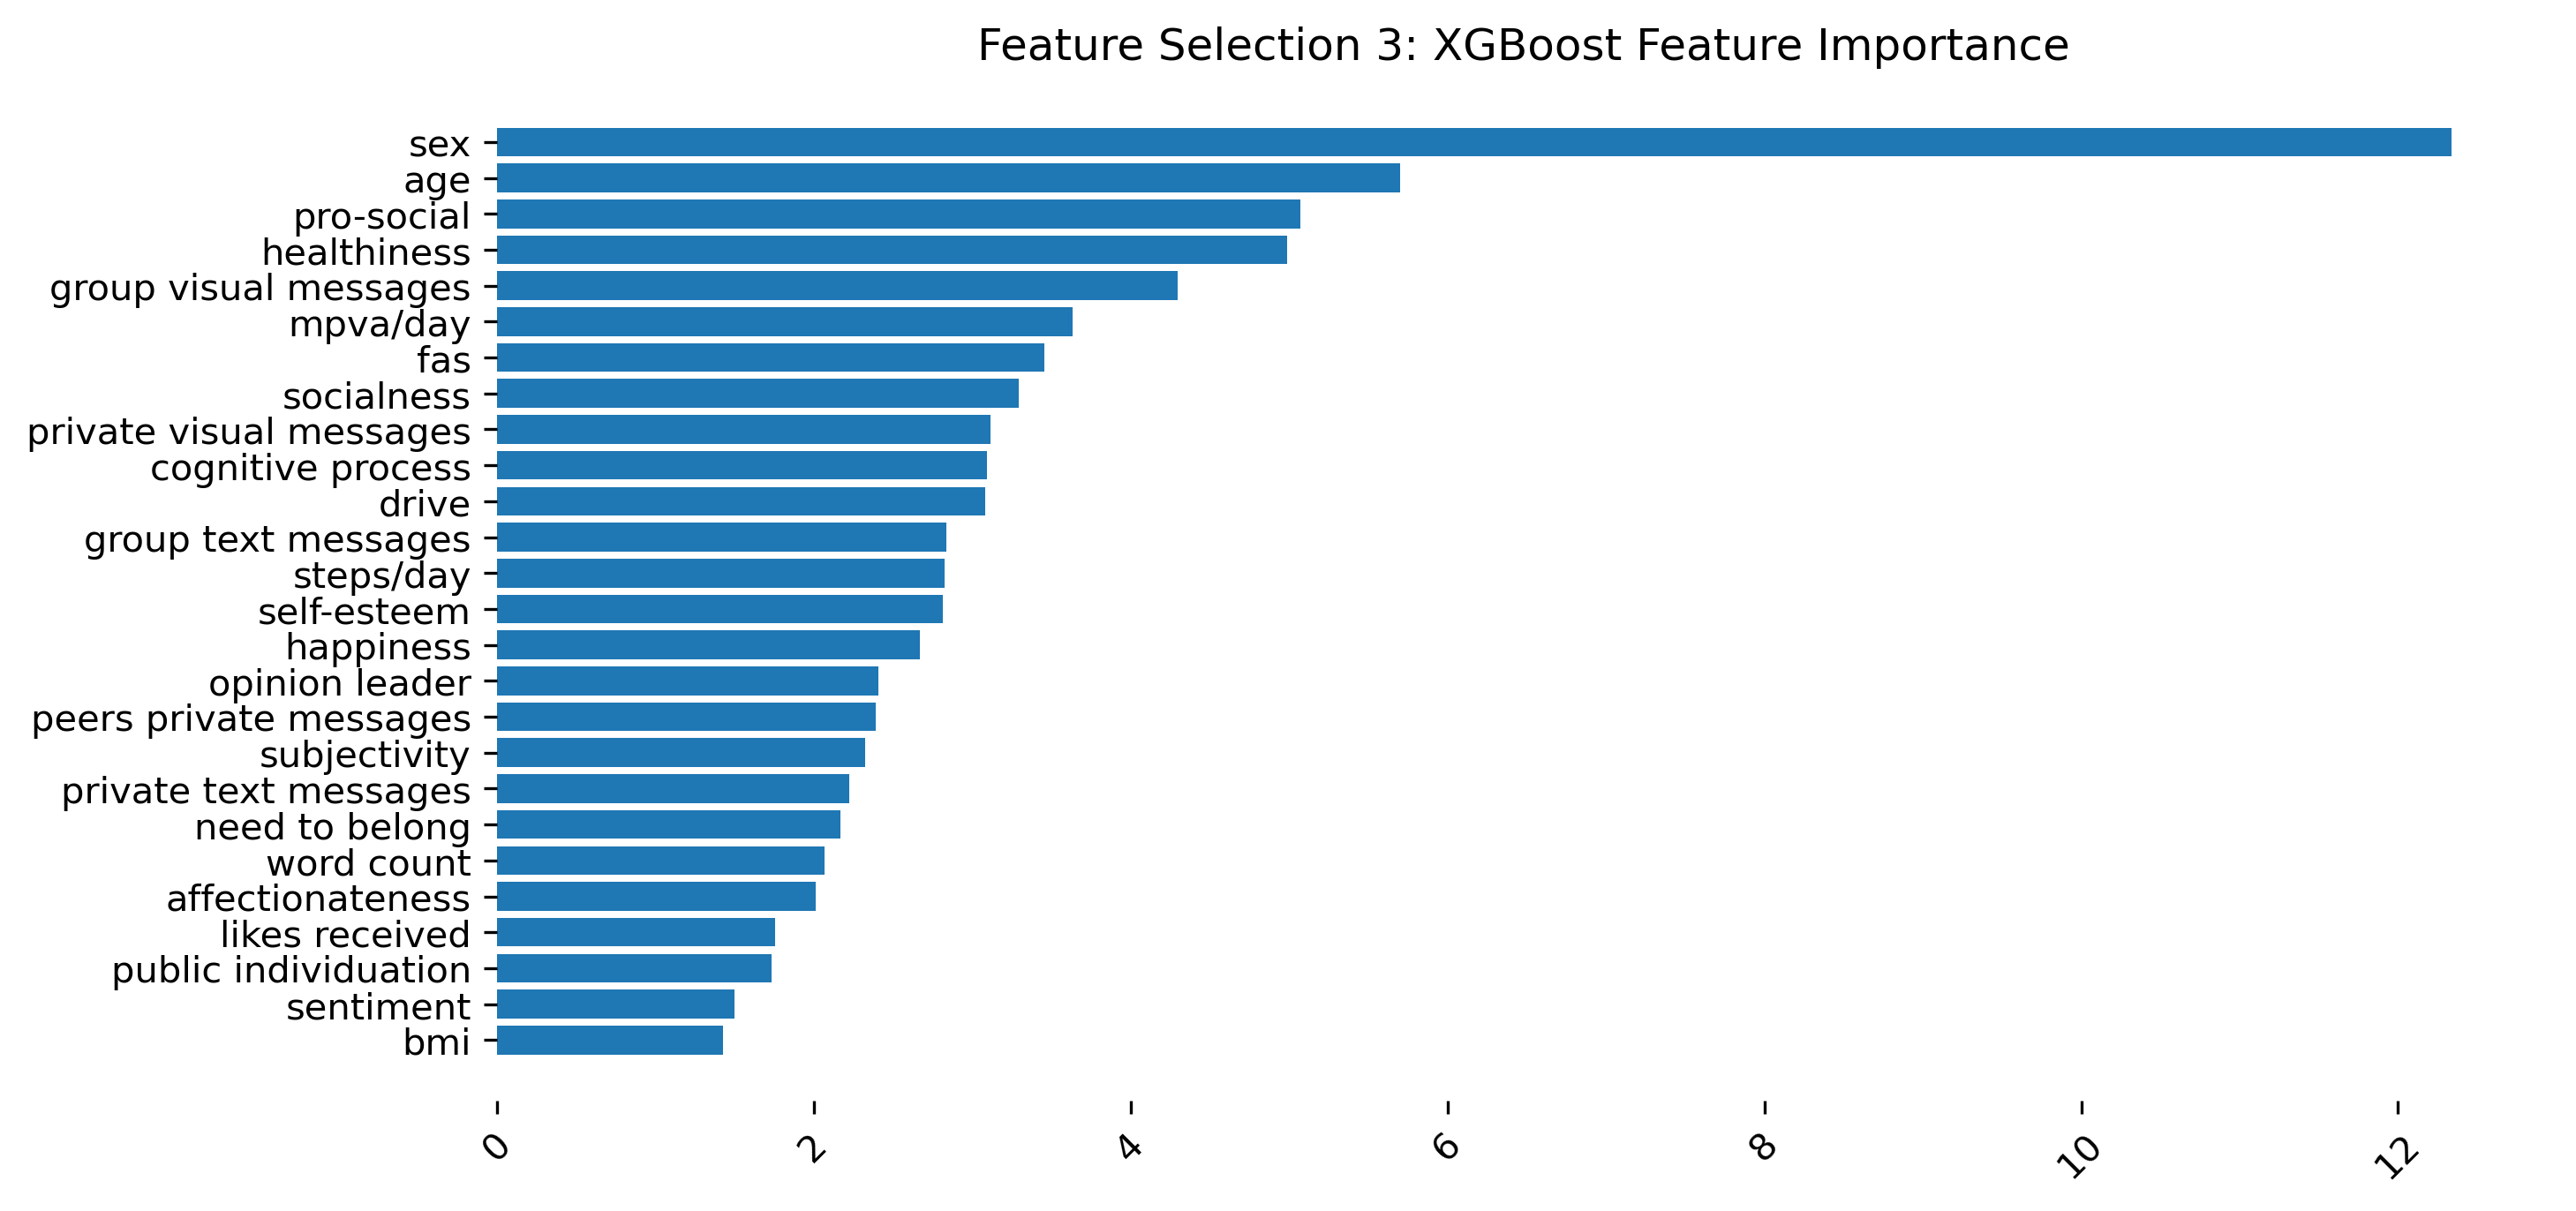

In [583]:
from matplotlib.pyplot import figure

figure(figsize=(10,5), dpi =300)
s = pyplot.barh(list(dict_features.keys()),list(dict_features.values()))
plt.xticks(rotation = 45)
plt.title("Feature Selection 3: XGBoost Feature Importance")
plt.box(False)
pyplot.show()

In [564]:
xgb_vars = []
for i in range(len(scores)):
    print(scores[i])
    if(scores[i]>=3):
        xgb_vars.append(names[i])
xgb_vars

2.068176507949829
2.009182929992676
3.0792312622070312
3.2924582958221436
1.50093412399292
4.986486911773682
3.0918612480163574
2.3219945430755615
1.756508469581604
2.835113763809204
4.297610759735107
2.220813035964966
3.11586594581604
2.3914144039154053
2.8227322101593018
3.635770797729492
1.426596760749817
2.4096484184265137
2.1652169227600098
2.6697423458099365
5.070714950561523
1.7333275079727173
2.813523769378662
3.452465295791626
5.700766086578369
12.339323043823242


['drives',
 'social',
 'health',
 'cogproc',
 'g_num_media',
 'i_num_media',
 'Minutes_MVPA',
 'prosocial_score',
 'fas',
 'age',
 'sex']

In [544]:
thresholds = sort(best_est._final_estimator.feature_importances_)
thresholds

array([0.01674262, 0.01761505, 0.02034243, 0.02061449, 0.02357989,
       0.02427224, 0.02541111, 0.02606359, 0.02725106, 0.02806578,
       0.02827978, 0.03133225, 0.03301968, 0.03312775, 0.03327306,
       0.03613804, 0.03628626, 0.03656799, 0.03864048, 0.04051834,
       0.04266962, 0.05043701, 0.0585217 , 0.05951021, 0.06690452,
       0.14481501], dtype=float32)

In [547]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel



# define the feature selection strategy
fs = SelectFromModel(best_est._final_estimator,threshold=0.03)


models1 = { 
    'AdaBoostClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('sfm',fs),('over', SMOTE(random_state=random_seed)), ('ab', AdaBoostClassifier(random_state=random_seed))]),
    'XGBoost': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('sfm',fs), ('over', SMOTE(random_state=random_seed)), ('xg',XGBClassifier(random_state=random_seed, scale_pos_weight = 9))]),
    'DummyClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('sfm',fs),('over', SMOTE(random_state=random_seed)), ('dm', DummyClassifier(random_state=random_seed))]),
    'EasyEnsembleClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('sfm',fs),('eec', EasyEnsembleClassifier(random_state=random_seed))]),
    'BalancedRandomForestClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('sfm',fs), ('brf', BalancedRandomForestClassifier(random_state=random_seed))]),
    'BalancedBaggingClassifier': imbPipeline(steps=[('i', SimpleImputer(strategy='mean')),('sfm',fs), ('bbc', BalancedBaggingClassifier(random_state=random_seed))]),
}

params1 = {     
     'AdaBoostClassifier':  { 'ab__n_estimators': list(range(1,20,2)),
                            'ab__learning_rate': [(0.97 + x/100) for x in range(0,8)],
                            'ab__algorithm': ['SAMME','SAMME.R']},
    
     'XGBoost':{ 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "xg__learning_rate": [0.01, 0.05,0.10, 0.15, 0.20, 0.25, 0.30] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "xg__max_depth": range(3,21,2),
    # Gamma specifies the minimum loss reduction required to make a split.
    "xg__gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "xg__colsample_bytree": [i/10.0 for i in range(0,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "xg__reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "xg__reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
         
    "xg__n_estimators" : [10, 100, 500, 1000, 2000]},
    
      'DummyClassifier' : {},
    
    'EasyEnsembleClassifier' : {'eec__n_estimators': list(range(1,200,20))},
    'BalancedRandomForestClassifier' : { 'brf__n_estimators': list(range(1,200,20)),
                                         'brf__bootstrap': [True, False],
                                         'brf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                                         'brf__max_features': ['auto', 'sqrt'],
                                         'brf__min_samples_leaf': [1, 2, 4],
                                         'brf__min_samples_split': [2, 5, 10],                                       
                                       },
    'BalancedBaggingClassifier' : {'bbc__n_estimators': list(range(1,200,20))},


}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring=['balanced_accuracy','f1','precision','recall','matthews_corrcoef'], n_jobs=3,refit='balanced_accuracy',random_seed = random_seed)
res3_3 = helper1.parameter_tuning_score_summary(X_train, X_test, y_train, y_test)
res3_3[2]

Running RandomizedSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:25:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for XGBoost.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for DummyClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for EasyEnsembleClassifier.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for BalancedRandomForestClassifier.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:47:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Running RandomizedSearchCV for BalancedBaggingClassifier.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:48:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bojansimoski/anaconda3/envs/jonas/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DONE!!!


,classifier,train_f1,train_balanced_accuracy,train_precision,train_recall,test_f1,test_balanced_accuracy,test_precision,test_recall,mcc_train,mcc_test
0,AdaBoostClassifier,0.340278,0.63325,0.232227,0.636364,0.411765,0.70933,0.285714,0.736842,0.193242,0.305697
1,XGBoost,0.832432,0.964612,0.712963,1.0,0.448276,0.723923,0.333333,0.684211,0.813942,0.34558
2,DummyClassifier,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
3,EasyEnsembleClassifier,0.481013,0.807433,0.317992,0.987013,0.346667,0.646651,0.232143,0.684211,0.439653,0.209716
4,BalancedRandomForestClassifier,0.548736,0.851954,0.38,0.987013,0.328767,0.62488,0.222222,0.631579,0.515025,0.17942
5,BalancedBaggingClassifier,0.693694,0.922374,0.531034,1.0,0.357143,0.640431,0.27027,0.526316,0.669769,0.220075


### Save the results

In [548]:
res1[2].to_csv('res1_predictions.csv')
res1[0].to_csv('res1_tunning.csv')
res2[2].to_csv('res2_predictions.csv')
res2[0].to_csv('res2_tunning.csv')
res3_1[2].to_csv('res3_1_predictions.csv')
res3_1[0].to_csv('res3_1_tunning.csv')
res3_2[2].to_csv('res3_2_predictions.csv')
res3_2[0].to_csv('res3_2_tunning.csv')
res3_3[2].to_csv('res3_2_predictions.csv')
res3_3[0].to_csv('res3_2_tunning.csv')
